In [ ]:
# https://medium.com/@vedantjumle/image-generation-with-diffusion-models-using-keras-and-tensorflow-9f60aae72ac

In [ ]:
!pip install tensorflow --quiet
!pip install tensorflow_datasets --quiet
!pip install tensorflow_addons --quiet
!pip install einops --quiet

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from inspect import isfunction
import math

from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import normalize
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow as tf

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

# configure the GPU
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

In [ ]:
# set the parameters for dataset
target_size = (32, 32)
channels = 1
BATCH_SIZE=64

# Normalization helper
def preprocess(x, y):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

def get_datasets():
    # Load the MNIST dataset
    train_ds = tfds.load('mnist', as_supervised=True, split="train")

    # Normalize to [-1, 1], shuffle and batch
    train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Return numpy arrays instead of TF tensors while iterating
    return tfds.as_numpy(train_ds)


train_ds = get_datasets()

In [ ]:
timesteps = 400

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)
    

In [ ]:
dataset = get_datasets()

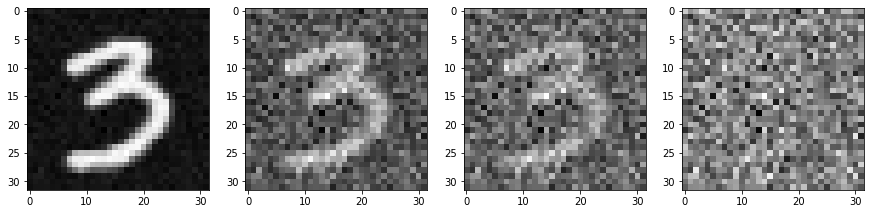

In [ ]:
# Let us visualize the output image at a few timestamps
sample_mnist = next(iter(dataset))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 100, 150, 355]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample_mnist, 0), np.array([i,]))
    plt.subplot(1, 4, index+1)
    plt.imshow(np.squeeze(np.squeeze(noisy_im, -1), 0), cmap='gray')
    

plt.show()

In [ ]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = nn.LayerNormalization(axis=3)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

In [ ]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=-1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            nn.LayerNormalization(axis=3)
        ])

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        return out

class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1)

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)

        return out

In [ ]:
init_dim = default(None, 64 // 3 * 2)

init_dim

42

In [ ]:
class Unet(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True
                 ):
        super(Unet, self).__init__()
        
        # determine dimensions
        self.channels = channels
        
        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')
        
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp
        
        self.time_mlp = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=time_dim),
            GELU(),
            nn.Dense(units=time_dim)
        ], name="time embeddings")
        
        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)
        
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])
  
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])
        
        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)
        
        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")
        
    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [ ]:
# create our unet model
unet = Unet(channels=1)

# create our checkopint manager
ckpt = tf.train.Checkpoint(unet=unet)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

# initialize the model in the memory of our GPU
test_images = np.ones([1, 32, 32, 1])
test_timestamps = generate_timestamp(0, 1)
k = unet(test_images, test_timestamps)

# create our optimizer, we will use adam with a Learning rate of 1e-4
opt = keras.optimizers.Adam(learning_rate=1e-4)

Initializing from scratch.


In [ ]:

def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [ ]:
rng = 0

def train_step(batch):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [ ]:
epochs = 10
for e in range(1, epochs+1):
    # this is cool utility in Tensorflow that will create a nice looking progress bar
    bar = tf.keras.utils.Progbar(len(dataset)-1)
    losses = []
    for i, batch in enumerate(iter(dataset)):
        # run the training loop
        loss = train_step(batch)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])

    avg = np.mean(losses)
    print(f"Average loss for epoch {e}/{epochs}: {avg}")
    ckpt_manager.save(checkpoint_number=e)

937/937 [==============================] - 685s 726ms/step - loss: 0.2291
Average loss for epoch 1/10: 0.22912971675395966
937/937 [==============================] - 658s 702ms/step - loss: 0.0695
Average loss for epoch 2/10: 0.06948236376047134
937/937 [==============================] - 657s 700ms/step - loss: 0.0530
Average loss for epoch 3/10: 0.052985068410634995
937/937 [==============================] - 661s 704ms/step - loss: 0.0462
Average loss for epoch 4/10: 0.04620202258229256
937/937 [==============================] - 661s 704ms/step - loss: 0.0424
Average loss for epoch 5/10: 0.0424426794052124
937/937 [==============================] - 680s 725ms/step - loss: 0.0399
Average loss for epoch 6/10: 0.03986399248242378
937/937 [==============================] - 671s 715ms/step - loss: 0.0371
Average loss for epoch 7/10: 0.03708615154027939
937/937 [==============================] - 674s 719ms/step - loss: 0.0356
Average loss for epoch 8/10: 0.03561614826321602
937/937 [=======

In [ ]:
!pwd

/content


In [ ]:
# Save a GIF using logged images
def save_gif(img_list, path="/content", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        im = (im + 1) * 127.5
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [ ]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

  0%|          | 0/399 [00:00<?, ?it/s]

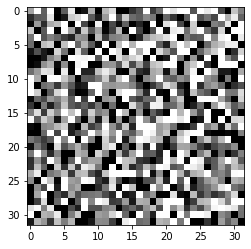

  6%|▋         | 25/399 [00:08<01:54,  3.26it/s]

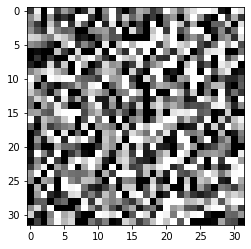

 13%|█▎        | 50/399 [00:16<01:46,  3.28it/s]

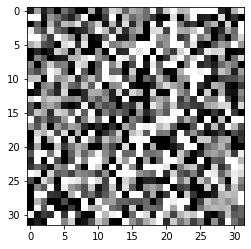

 19%|█▉        | 75/399 [00:23<01:40,  3.23it/s]

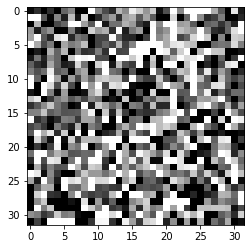

 25%|██▌       | 100/399 [00:31<01:29,  3.32it/s]

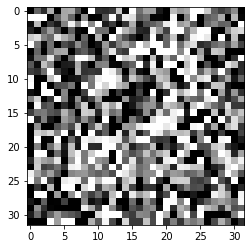

 31%|███▏      | 125/399 [00:39<01:23,  3.29it/s]

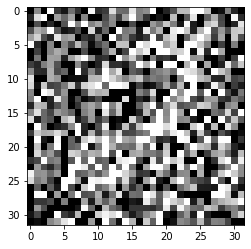

 38%|███▊      | 150/399 [00:47<01:16,  3.24it/s]

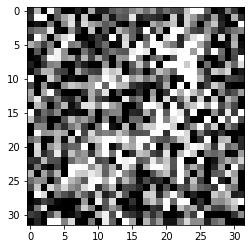

 44%|████▍     | 175/399 [00:55<01:08,  3.28it/s]

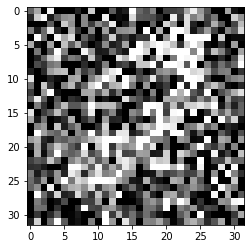

 50%|█████     | 200/399 [01:03<01:02,  3.17it/s]

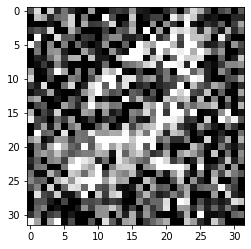

 56%|█████▋    | 225/399 [01:11<00:52,  3.28it/s]

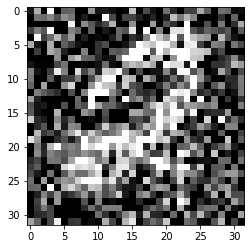

 63%|██████▎   | 250/399 [01:18<00:45,  3.25it/s]

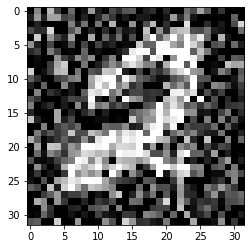

 69%|██████▉   | 275/399 [01:26<00:38,  3.25it/s]

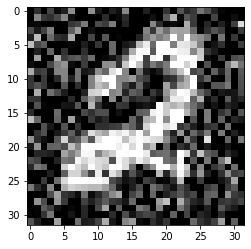

 75%|███████▌  | 300/399 [01:34<00:30,  3.24it/s]

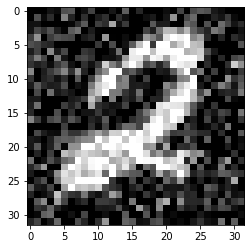

 81%|████████▏ | 325/399 [01:42<00:22,  3.23it/s]

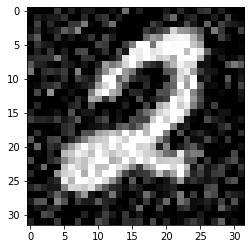

 88%|████████▊ | 350/399 [01:50<00:15,  3.26it/s]

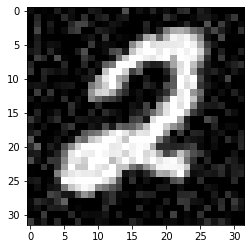

 94%|█████████▍| 375/399 [01:58<00:07,  3.28it/s]

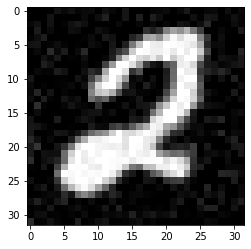

100%|██████████| 399/399 [02:06<00:00,  3.17it/s]


TypeError: ignored

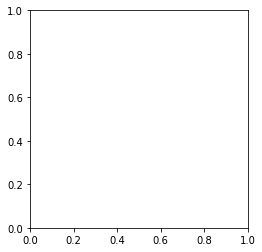

In [ ]:
x = tf.random.normal((1,32,32,1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0),-1))

for i in tqdm(range(timesteps-1)):
    t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
    pred_noise = unet(x, t)
    x = ddpm(x, pred_noise, t)
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))

    if i % 25==0:
        plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255)[:,:,0], np.uint8), cmap="gray")
        plt.show()

save_gif(img_list + ([img_list[-1]] * 100), "ddpm.gif", interval=20)

plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255)[:,:,0], np.uint8))
plt.show()

In [ ]:
def ddim(x_t, pred_noise, t, sigma_t):
    alpha_t_bar = np.take(alpha_bar, t)
    alpha_t_minus_one = np.take(alpha, t-1)

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

  0%|          | 0/10 [00:00<?, ?it/s]

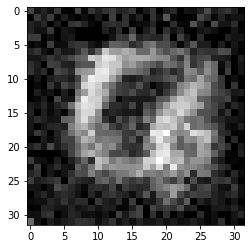

 10%|█         | 1/10 [00:00<00:04,  1.88it/s]

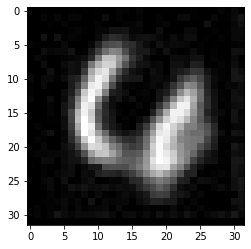

 20%|██        | 2/10 [00:01<00:04,  1.89it/s]

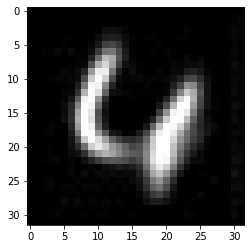

 30%|███       | 3/10 [00:01<00:03,  1.92it/s]

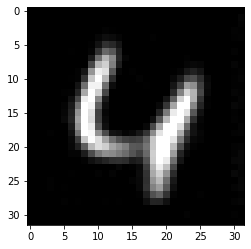

 40%|████      | 4/10 [00:02<00:03,  1.99it/s]

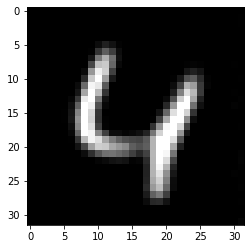

 50%|█████     | 5/10 [00:02<00:02,  2.06it/s]

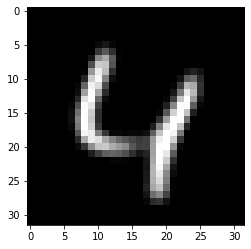

 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

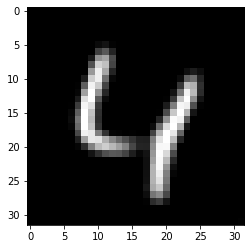

 70%|███████   | 7/10 [00:03<00:01,  2.11it/s]

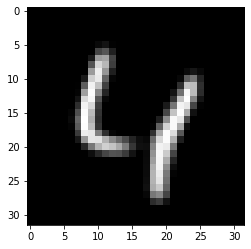

 80%|████████  | 8/10 [00:03<00:00,  2.11it/s]

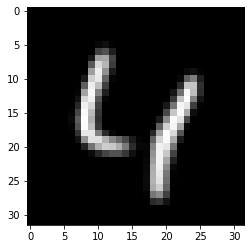

 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

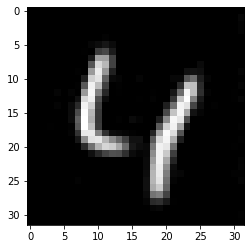

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


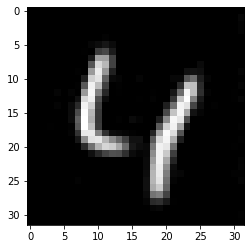

In [ ]:
# Define number of inference loops to run
inference_timesteps = 10

# Create a range of inference steps that the output should be sampled at
inference_range = range(0, timesteps, timesteps // inference_timesteps)

x = tf.random.normal((1,32,32,1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0),-1))

# Iterate over inference_timesteps
for index, i in tqdm(enumerate(reversed(range(inference_timesteps))), total=inference_timesteps):
    t = np.expand_dims(inference_range[i], 0)

    pred_noise = unet(x, t)

    x = ddim(x, pred_noise, t, 0)
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))   
    
    if index % 1 == 0:
        plt.imshow(np.array(np.clip((np.squeeze(np.squeeze(x, 0),-1) + 1) * 127.5, 0, 255), np.uint8), cmap="gray")
        plt.show()

plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255)[:,:,0], np.uint8), cmap="gray")
plt.show()